In [18]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import backtest

### Data

In [19]:

# import data
returns_df = pd.read_csv('10_Industry_Portfolios.csv', skiprows=11, nrows=1182, index_col=0)
returns_df.index = pd.to_datetime(returns_df.index, format='%Y%m')

# change returns of -99.99 or -999 to NaN
returns_df.replace(-99.99, np.nan, inplace=True)
returns_df.replace(-999, np.nan, inplace=True)

rf_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3, nrows=1182, index_col=0)
rf_df.index = pd.to_datetime(rf_df.index, format='%Y%m')
rf = rf_df[['RF']]
rf = rf.squeeze()

mkt_subrf = rf_df[['Mkt-RF']]
mkt_subrf = mkt_subrf.squeeze()

returns_df.dropna()
rf.dropna()

num_firms = pd.read_csv('10_Industry_Portfolios.csv', skiprows=2587, nrows=1182, index_col=0)
num_firms.index = pd.to_datetime(num_firms.index, format='%Y%m')

firm_size = pd.read_csv('10_Industry_Portfolios.csv', skiprows=3773, nrows=1182, index_col=0)
firm_size.index = pd.to_datetime(firm_size.index, format='%Y%m')

# create market cap df from num_firms and firm_size
mktcap_df = num_firms * firm_size

### Compute portfolio weights

In [20]:
portfolios = backtest.compute_portfolio_weights(returns_df, rf, mktcap_df, window_length=60)
portfolios['max_sharpe_unconstrained'].tail()

,NoDur,Durbl,Manuf,Enrgy,HiTec,Telcm,Shops,Hlth,Utils,Other
2024-08-01,-1.602620,-0.184356,-0.050960,1.090564,4.897924,-4.809500,-2.176061,1.430442,0.974499,1.430067
2024-09-01,-0.711588,-0.250610,-0.883209,0.837761,4.360208,-4.531295,-2.240551,1.480012,0.462699,2.476573
2024-10-01,-0.711538,-0.081821,-0.898638,0.670868,3.704659,-3.408833,-1.722556,1.054507,0.687999,1.705352
2024-11-01,-0.871192,-0.196314,-1.689171,0.791987,4.253682,-3.673980,-1.536804,0.490914,1.033716,2.397163
2024-12-01,-1.637692,-0.060268,-2.152821,0.848452,3.685528,-3.637617,-0.595975,-0.118396,1.710255,2.958533


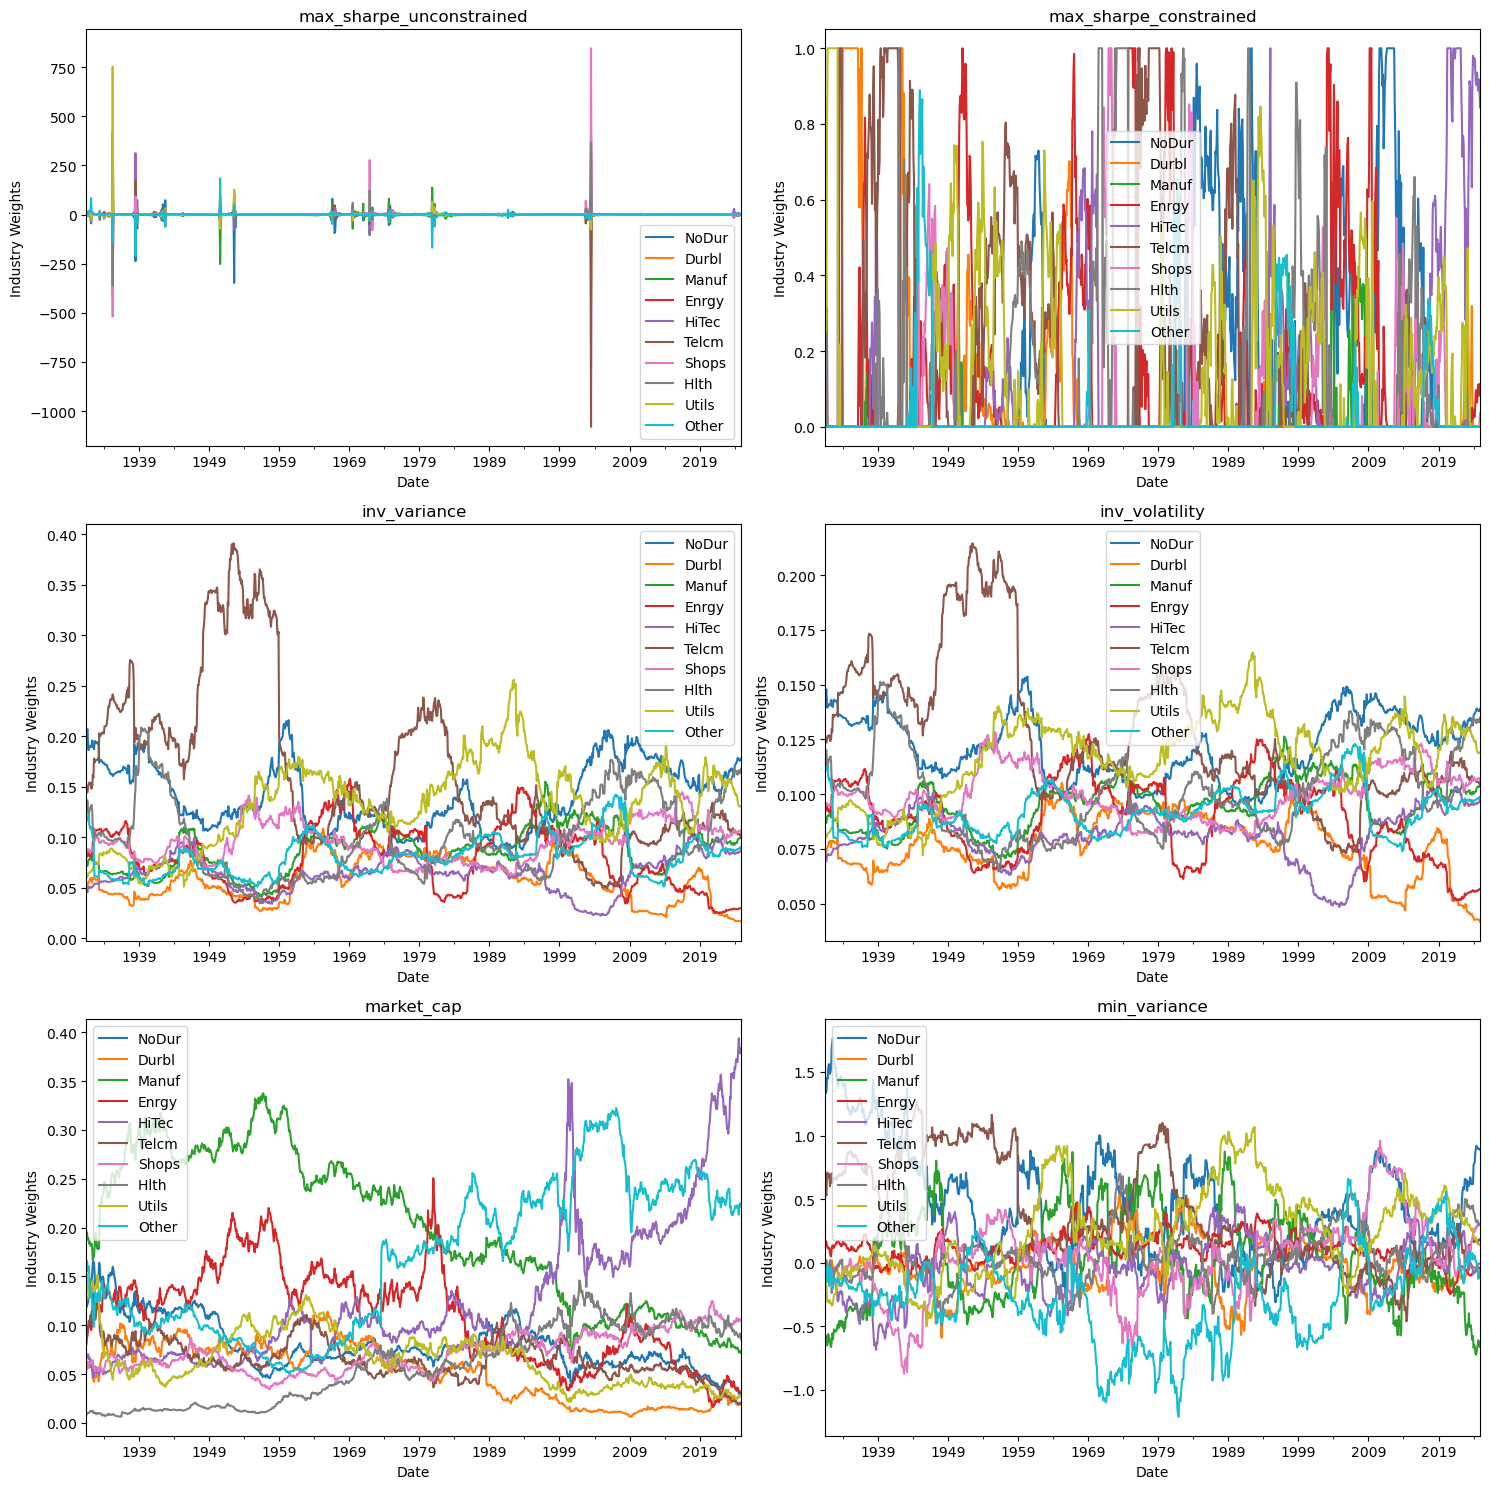

In [21]:
p_names = ['max_sharpe_unconstrained', 'max_sharpe_constrained',
                  'inv_variance', 'inv_volatility', 'equal_weight',
                  'market_cap', 'min_variance']

# for each strategy p in p_names, plot industry weights (6 plots total - we exclude equal weighting)
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
plot_index = 0
for p in p_names:
    if p == 'equal_weight':
        continue
    ax = axs[plot_index // 2, plot_index % 2]
    portfolios[p].plot(ax=ax)
    ax.set_title(p)
    ax.set_ylabel('Industry Weights')
    ax.set_xlabel('Date')
    plot_index += 1
plt.tight_layout()
plt.show()

### Compute monthly returns for each strategy

In [22]:
monthly_returns = pd.DataFrame(index=portfolios[p_names[0]].index)

for strat in p_names:
    strat_weights = portfolios[strat]
    strat_returns = returns_df.loc[strat_weights.index]
    # Compute the weighted returns for each period
    monthly_returns[strat] = (strat_weights * strat_returns).sum(axis=1)

monthly_returns

,max_sharpe_unconstrained,max_sharpe_constrained,inv_variance,inv_volatility,equal_weight,market_cap,min_variance
1931-07-01,29.838817,-4.056951,-4.394218,-4.646231,-4.919,-6.499111,1.375774
1931-08-01,17.074600,-0.020493,0.531346,0.686608,0.812,0.139406,1.967926
1931-09-01,-21.240639,-28.230428,-27.801642,-28.576073,-29.382,-28.979582,-17.630113
1931-10-01,-67.693447,9.151599,8.411285,8.869539,9.330,8.084599,4.602691
1931-11-01,-238.681136,-4.770000,-7.926670,-8.083310,-8.199,-9.085621,-3.122428
...,...,...,...,...,...,...,...
2024-08-01,6.922986,0.924621,3.046167,2.472924,1.575,2.093735,6.076010
2024-09-01,-28.824983,2.274460,2.288447,2.593588,3.135,2.177889,1.001708
2024-10-01,-2.784579,-0.237175,-1.099623,-1.010721,-1.015,-0.589349,-0.843588
2024-11-01,-10.161727,5.109976,5.658203,6.692650,8.412,6.855432,0.217701


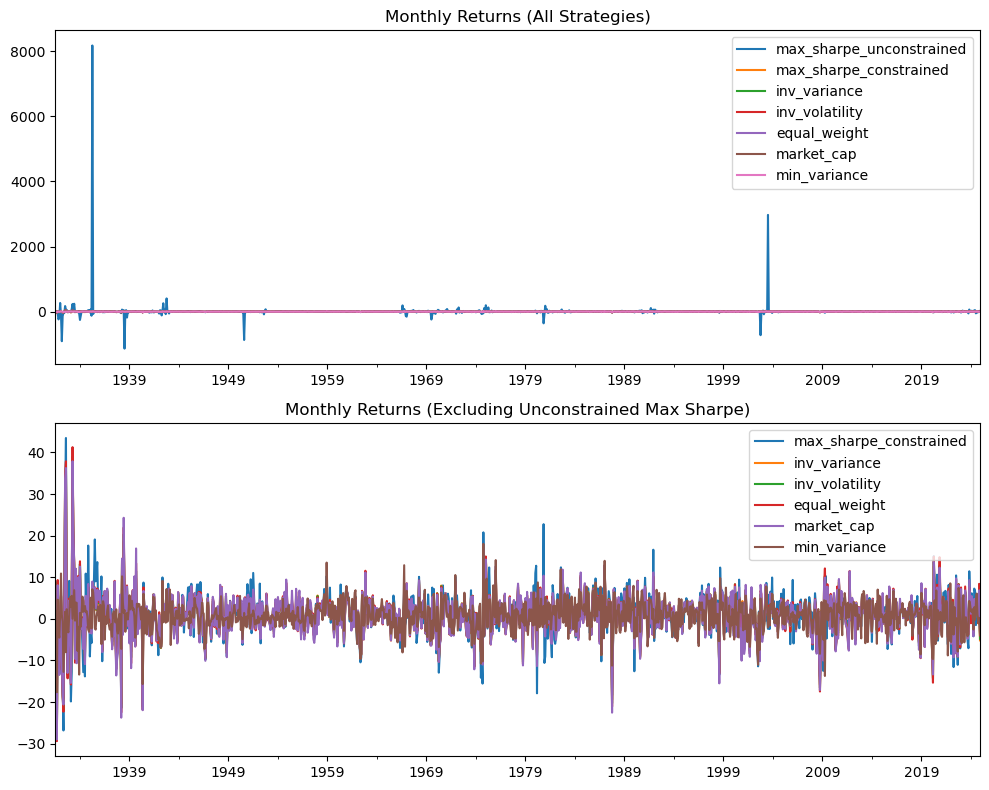

In [23]:
# plot monthly returns series
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

monthly_returns.plot(ax=axes[0])
axes[0].set_title('Monthly Returns (All Strategies)')

monthly_returns.drop('max_sharpe_unconstrained', axis=1).plot(ax=axes[1])
axes[1].set_title('Monthly Returns (Excluding Unconstrained Max Sharpe)')

plt.tight_layout()
plt.show()


### Compare performance

In [24]:
# Function to compute Jensen's alpha and Treynors Ratio
def jensens_alpha_treynor(excess_return, excess_market):
    """
    computes Jensen's Alpha and Treynors ratio for a portfolio.
    Parameters:
    :excess_return: DataFrame of excess portfolio returns (columns = portfolio)
    :excess_market: Series of market returns

    """

    # Compute mean excess returns
    mean_excess_return = np.sqrt(12) * excess_return.mean(axis=0)
    mean_excess_market = np.sqrt(12) * excess_market.mean()

    results = {}
    for portfolio in excess_return.columns:
        y = excess_return[portfolio].dropna()
        x = excess_market.loc[y.index].dropna()

        # Align data
        aligned = pd.concat([y, x], axis=1).dropna()
        if aligned.empty:
            results[portfolio] = np.nan
            continue

        # Regression to find Beta
        X = sm.add_constant(aligned.iloc[:, 1].values.reshape(-1, 1))  # Market excess return (2D)
        model = sm.OLS(aligned.iloc[:, 0].values, X).fit()

        beta = model.params[1]  # Market Beta
        alpha = mean_excess_return[portfolio] - beta * mean_excess_market  # Jensen’s Alpha (Intercept)
        treynor_ratio = mean_excess_return[portfolio] / beta if beta != 0 else np.nan # Treynor Ratio

        results[portfolio] = {"Jensen's Alpha": alpha, "Treynor's Ratio": treynor_ratio}


    return pd.DataFrame(results).T

In [ ]:
# periods of interest
periods = {
    'Jul1931-Dec2024': ('1931-07-01', '2024-12-31'),
    'Jan1990-Dec2024': ('1990-01-01', '2024-12-31'),
    'Jan2000-Dec2024': ('2000-01-01', '2024-12-31')
}

performance_results = {}

for period_label, (start_date, end_date) in periods.items():
    period_returns = monthly_returns.loc[start_date:end_date]

    avg_monthly = period_returns.mean()

    total_return = ((1 + period_returns / 100).prod() - 1) * 100
    
    excess_returns = period_returns.subtract(rf.loc[start_date:end_date], axis=0)
    excess_market = mkt_subrf.loc[start_date:end_date]
    sharpe_ratio = (excess_returns.mean() / excess_returns.std()) * np.sqrt(12)
    
    jensen_treynor = jensens_alpha_treynor(excess_returns, excess_market)

    performance_results[period_label] = pd.DataFrame({
        'Average Monthly Return': avg_monthly,
        'Total Return': total_return,
        'Sharpe Ratio': sharpe_ratio,
        'Jensen\'s Alpha': jensen_treynor.iloc[:,0]
    })

combined_performance = pd.concat(performance_results, axis=1)

combined_performance

Jul1931-Dec2025                             \
                         Average Monthly Return  Total Return Sharpe Ratio   
max_sharpe_unconstrained               7.801841 -1.702332e+06     0.097444   
max_sharpe_constrained                 1.015904  1.886686e+06     0.495927   
inv_variance                           0.978018  1.678318e+06     0.527284   
inv_volatility                         0.998281  1.889944e+06     0.519157   
equal_weight                           1.017845  2.079719e+06     0.509270   
market_cap                             0.980424  1.271993e+06     0.472654   
min_variance                           0.760790  2.391164e+05     0.473891   

                                               Jan1990-Dec2025                \
                         Jensen's Alpha Average Monthly Return  Total Return   
max_sharpe_unconstrained      17.557093               6.342616 -13019.409500   
max_sharpe_constrained         0.450147               0.904673   2853.951597   
inv_variance                   0.327426               0.919988   3357.501465   
inv_volatility                 0.283703               0.941722   3587.844571   
equal_weight                   0.236389               0.968950   3872.513566   
market_cap                     0.025233               0.956056   3531.324186   
min_variance                   0.845938               0.725729   1505.293057   

                                                            Jan2000-Dec2025  \
                         Sharpe Ratio Jensen's Alpha Average Monthly Return   
max_sharpe_unconstrained     0.141506      19.809346               7.866511   
max_sharpe_constrained       0.543352       0.240589               0.821720   
inv_variance                 0.637004       0.367239               0.787475   
inv_volatility               0.630094       0.325058               0.797446   
equal_weight                 0.617740       0.274712               0.813270   
market_cap                   0.580449       0.058489               0.759312   
min_variance                 0.496882       0.616820               0.577796   

                                                                   
                         Total Return Sharpe Ratio Jensen's Alpha  
max_sharpe_unconstrained -3737.355924     0.151034      25.590663  
max_sharpe_constrained     771.947119     0.529649       0.666475  
inv_variance               734.489714     0.562751       0.552511  
inv_volatility             740.646696     0.545535       0.482386  
equal_weight               751.140501     0.523560       0.403222  
market_cap                 609.567086     0.465142       0.092119  
min_variance               363.642666     0.414030       0.595444